# Imports and directory for data

In [1]:
from pathlib import Path
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import UnitaryGate
from qiskit.compiler import transpile
from qiskit import transpile
from qiskit.quantum_info import Operator, Pauli, SparsePauliOp
from qiskit_aer import AerSimulator
from scipy.linalg import expm
from scipy.spatial.distance import cdist
from matplotlib import pyplot as plt

IMAGE_SIZE = 16
N_QUBITS = 16
BATCH_SIZE = 16

BASE_DIR = Path(
    "/Users/oliverjackson/Programming/Quantum computing/oliverdancinganimationpieces"
)
INPUT_DIR = BASE_DIR / "input"
OUTPUT_DIR = BASE_DIR / "output"
TRAIN_DIR = BASE_DIR / "training"


# Import dataset

#### Additional test dataset

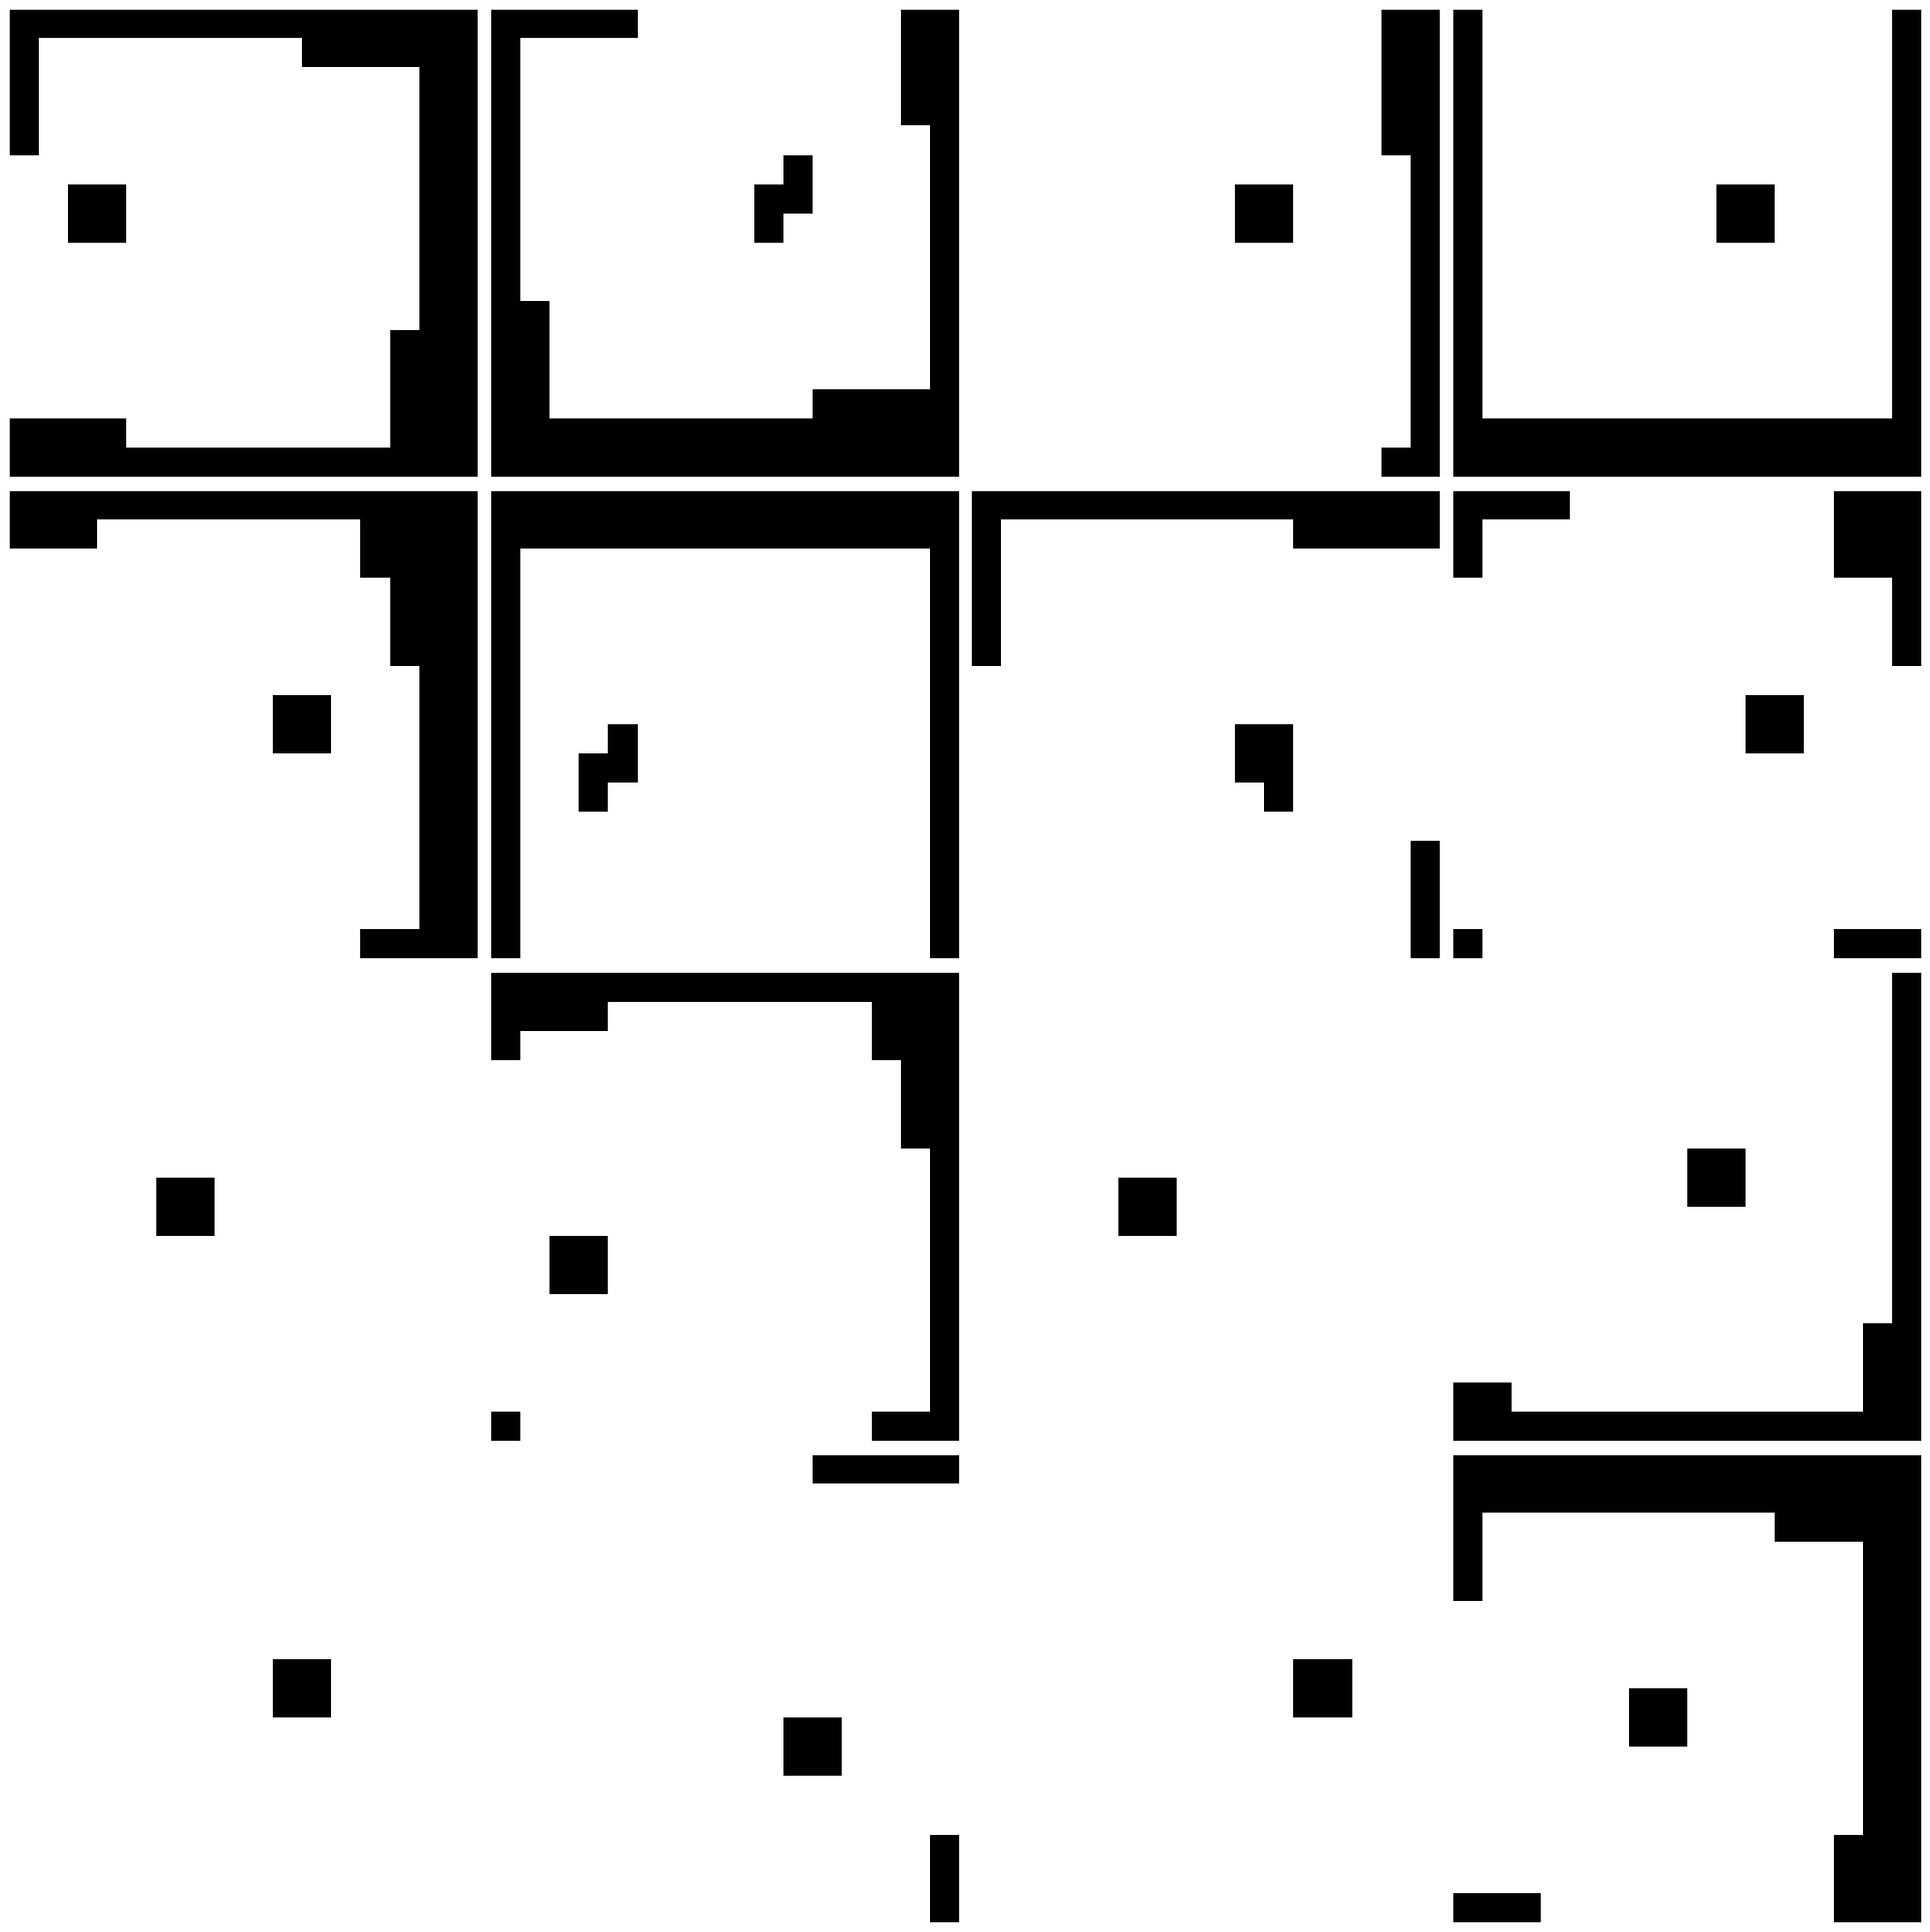

In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

def create_dataset(directory):
    # Define basic transforms for loading images
    base_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
    ])
    
    # Define augmentation transforms
    augment_transforms = transforms.Compose([
        transforms.RandomRotation(20),
        transforms.RandomAffine(
            degrees=0,
            translate=(0.1, 0.1),
            scale=(0.9, 1.1)
        ),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    
    # List and sort image files
    image_files = sorted([f for f in os.listdir(directory) 
                         if f.endswith(('.png', '.jpg', '.jpeg'))])
    
    # Load and transform original images
    original_images = []
    labels = []
    augmented_images = []
    
    # Load original images
    for filename in image_files:
        image_path = os.path.join(directory, filename)
        image = Image.open(image_path).convert('L')  # Convert to grayscale
        image = base_transform(image)
        original_images.append(image)
        labels.append(filename)
    
    # Create augmented versions
    for image in original_images:
        # Add original image
        augmented_images.append(image)
        
        # Create 15 augmented versions of each image (16 total per original)
        for _ in range(15):
            aug_image = augment_transforms(image)
            augmented_images.append(aug_image)
    
    # Stack all images into a single tensor
    augmented_images = torch.stack(augmented_images)
    
    # Create dataloader
    dataset = torch.utils.data.TensorDataset(augmented_images)
    dataloader = DataLoader(
        dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True, 
        drop_last=True,
        pin_memory=True
    )
    
    return dataloader, labels

# Create the dataloader
dataloader, labels = create_dataset(TRAIN_DIR)

# Visualize some augmented images
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
dataiter = iter(dataloader)
batch = next(dataiter)

for i in range(4):
    for j in range(4):
        idx = i * 4 + j
        if idx < len(batch[0]):
            image = batch[0][idx].squeeze()
            image = image * 0.5 + 0.5  # Denormalize
            axes[i, j].imshow(image, cmap='gray')
            axes[i, j].axis('off')
            
plt.tight_layout()
plt.show()

In [3]:
# Setup connection aka iterator (PyTorch version)
dataiter = iter(dataloader)

# Getting data out of the pipeline (PyTorch version)
print(next(dataiter)[0])

tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1.,  1.,  1.,  ..., -1., -1., -1.],
          [-1.,  1.,  1.,  ..., -1., -1., -1.],
          ...,
          [ 1.,  1.,  1.,  ...,  1., -1., -1.],
          [ 1.,  1.,  1.,  ...,  1., -1., -1.],
          [-1.,  1.,  1.,  ..., -1., -1., -1.]]],


        [[[-1.,  1.,  1.,  ...,  1.,  1., -1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          ...,
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [-1.,  1.,  1.,  ...,  1.,  1., -1.]]],


        [[[ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          ...,
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.]]],


        ...,


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., 

### Visualization check

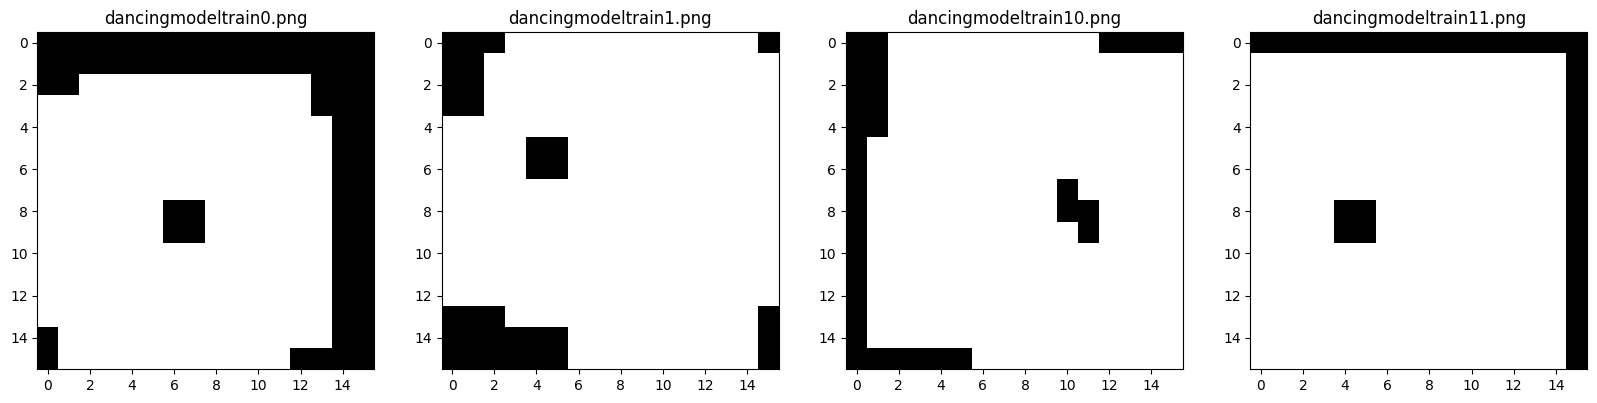

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
dataiter = iter(dataloader)
batch = next(dataiter)
# Loop four times and visualize images
for idx in range(4):
    # Get image from batch (denormalize it first for proper visualization)
    image = batch[0][idx].squeeze()  # Remove channel dimension
    image = image * 0.5 + 0.5  # Denormalize: inverse of normalize transform
    
    # Plot the image using a specific subplot
    ax[idx].imshow(image, cmap='gray')  # Use gray colormap since images are grayscale
    # give it a title
    ax[idx].title.set_text(labels[idx])

plt.show()

In [5]:
# Reload the dataset 
dataloader, labels = create_dataset(str(TRAIN_DIR))

# Configure the dataloader with similar settings
dataloader = DataLoader(
    dataloader.dataset,  # Use the dataset from your existing dataloader
    batch_size=16,      # Equivalent to ds.batch(16)
    shuffle=True,       # Equivalent to ds.shuffle
    pin_memory=True     # Equivalent to ds.prefetch for better performance
)

In [6]:
batch = next(iter(dataloader))
print(f"Batch shape: {batch[0].shape}")

Batch shape: torch.Size([16, 1, 16, 16])


# Build Neural Network

### Build quantum generator 

/var/folders/f4/4chqx5px2zd7m2tgwhv5j2380000gn/T/ipykernel_72433/2453084155.py:27: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler(
/var/folders/f4/4chqx5px2zd7m2tgwhv5j2380000gn/T/ipykernel_72433/2453084155.py:31: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = SamplerQNN(


Number of trainable parameters: 112


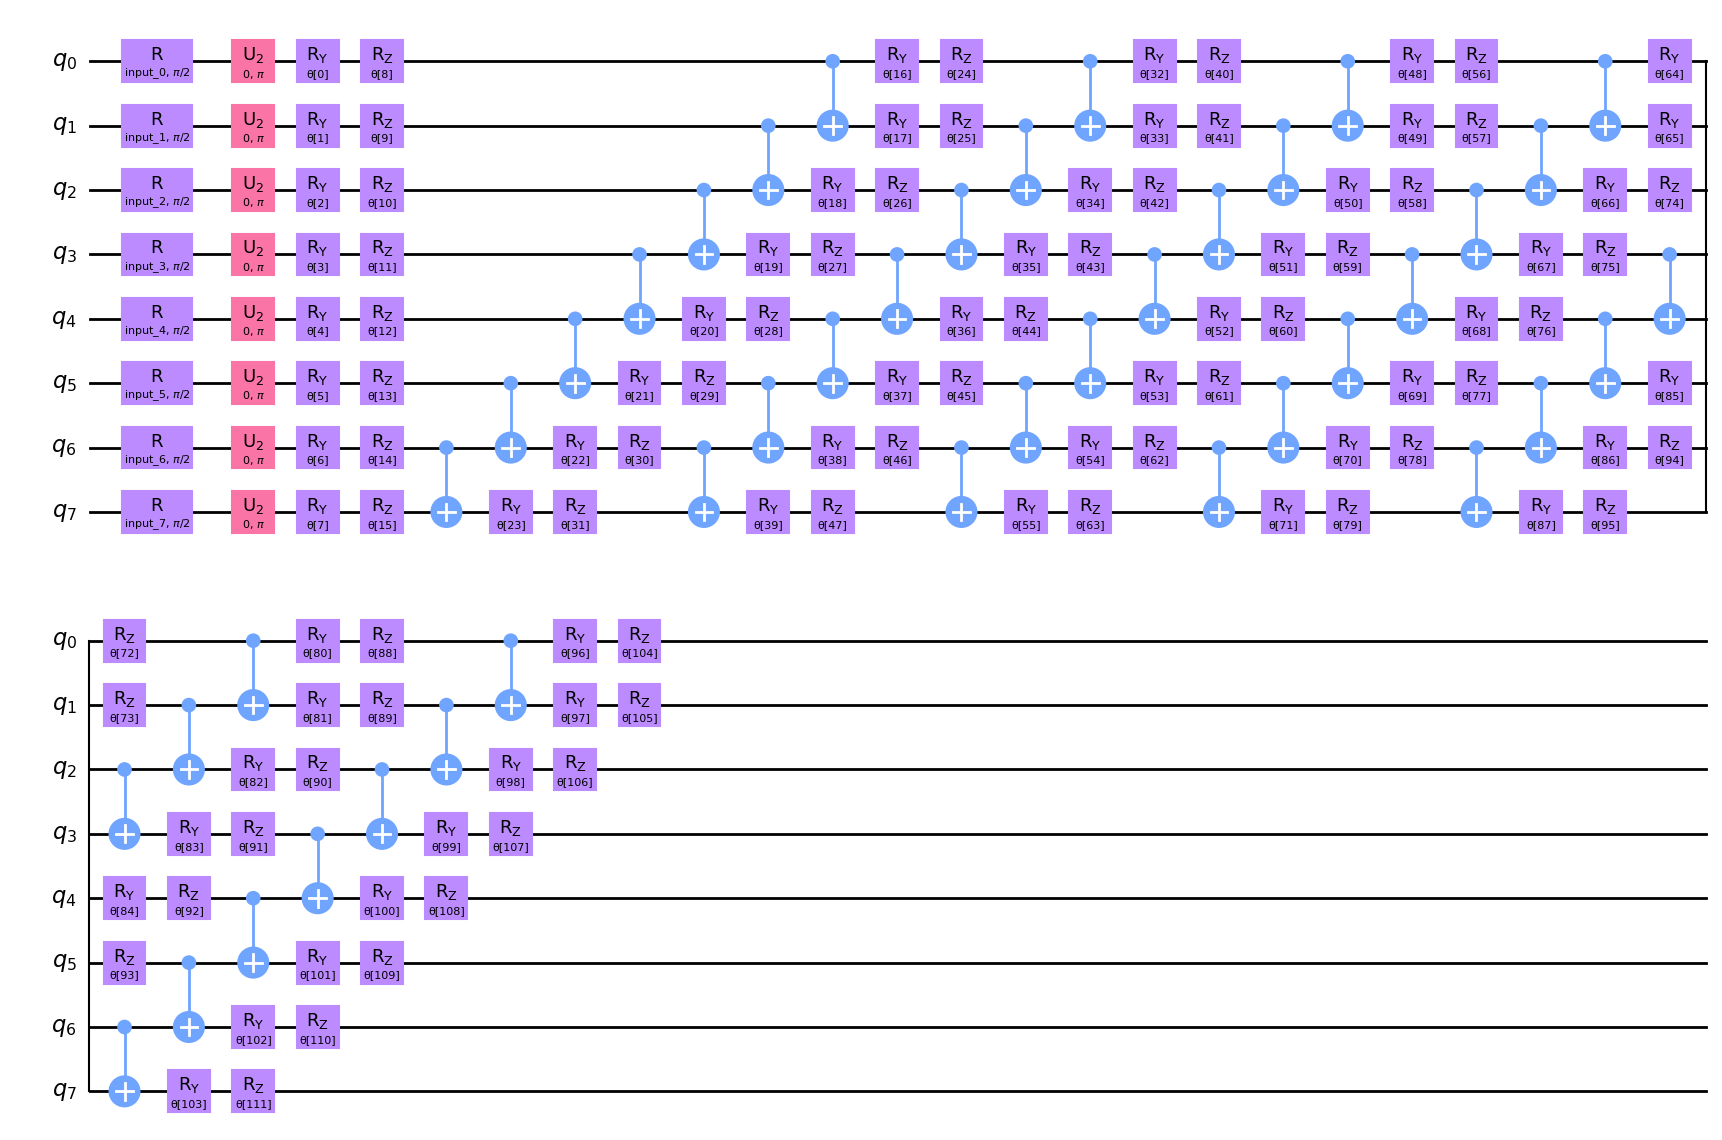

In [4]:
import random

import time
from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2
from qiskit.primitives import Sampler 
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit.transpiler import PassManager
import numpy as np

def build_quantum_generator(image_size=16):
    num_qubits = 8
    qc = QuantumCircuit(num_qubits)
    # Create input parameters to vary output
    input_params = [Parameter(f'input_{i}') for i in range(num_qubits)]

    # Add input encoding layer
    for i in range(num_qubits):
        qc.ry(input_params[i], i)  # Encode inputs using RY gates

    qc.h(qc.qubits)
    # Add variational layers using EfficientSU2
    ansatz = EfficientSU2(num_qubits, reps=6)
    qc.compose(ansatz, inplace=True)
    # Use standard Sampler instead of StatevectorSampler
    sampler = Sampler(
        options={'pass_manager': PassManager()}
    )
    
    qnn = SamplerQNN(
        circuit=qc,
        sampler=sampler,
        input_params=input_params,
        weight_params=qc.parameters[num_qubits:],
        sparse=False
    )

    initial_weights = np.random.random(len(qc.parameters) - num_qubits)
    # Set seed
    np.random.seed(int(time.time())) 
    return TorchConnector(qnn, initial_weights), len(qc.parameters) - num_qubits, qc

# Create the generator and get the circuit
quantum_generator, num_params, quantum_circuit = build_quantum_generator()

print(f"Number of trainable parameters: {num_params}")
quantum_circuit.decompose().draw(output="mpl", style="clifford")

#### Test that we can properly produce noise with the generator

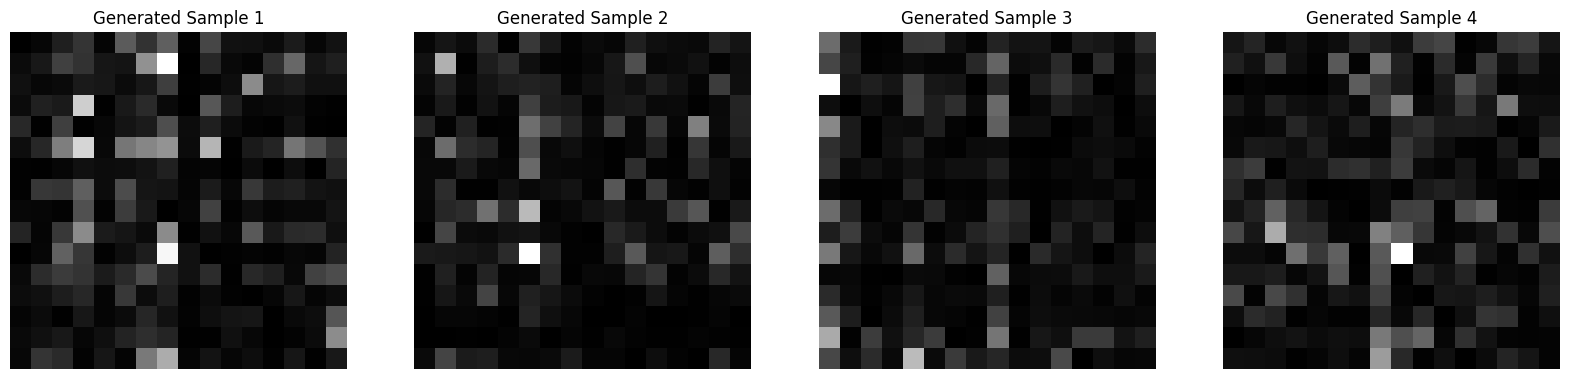

In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Create figure for visualization
fig, ax = plt.subplots(ncols=4, figsize=(20,20))

# Generate and plot 4 images
for idx in range(4):
    # Generate random parameters for input_parameters
    noisy_input = 2 * np.pi * np.random.random(8) # 8 qubits noisy_input, dtype=torch.float32
    # Generate output from quantum generator with empty tensor as input
    with torch.no_grad():
        output = quantum_generator(torch.tensor(noisy_input, dtype=torch.float32))

        
    # Reshape the output to match image dimensions (16x16)
    image = output.numpy().reshape(16, 16)
    
    # Plot the image
    ax[idx].imshow(image, cmap='gray')
    ax[idx].title.set_text(f'Generated Sample {idx+1}')
    ax[idx].axis('off')

plt.show()

### Build a hamiltonian and test that it evolves our images

In [6]:
def create_hamiltonian_tensor(num_qubits=8):
    # Initialize Hamiltonian matrix
    dim = 2**num_qubits
    H = torch.zeros((dim, dim), dtype=torch.complex64)
    
    # Add X terms for each qubit
    for i in range(num_qubits):
        # Create X operator for this qubit
        X_i = torch.eye(2**i, dtype=torch.complex64)
        X_local = torch.tensor([[0, 1], [1, 0]], dtype=torch.complex64)
        X_rest = torch.eye(2**(num_qubits-i-1), dtype=torch.complex64)
        
        # Construct full operator using tensor products
        X_term = torch.kron(torch.kron(X_i, X_local), X_rest)
        
        # Add to Hamiltonian
        H += X_term
    
    return H

def evolve_state_torch(state, hamiltonian, time):
    # Calculate evolution operator U = exp(-iHt)
    evolution_op = torch.matrix_exp(-1j * time * hamiltonian)
    
    # Reshape state if needed
    if len(state.shape) == 1:
        state = state.unsqueeze(0)
    
    # Apply evolution operator
    evolved_state = torch.matmul(evolution_op, state.T)
    
    return evolved_state.T

def evolve_generated_image(quantum_generator, hamiltonian_tensor, time_point, noisy_input):
    with torch.no_grad():
        # Generate initial state
        initial_state = quantum_generator(torch.tensor(noisy_input, dtype=torch.float32))
        
        # Convert to complex if needed
        if not torch.is_complex(initial_state):
            initial_state = initial_state.to(torch.complex64)
        
        # Evolve the state
        evolved_state = evolve_state_torch(initial_state, hamiltonian_tensor, time_point)
        
        return evolved_state

# Create PyTorch Hamiltonian
hamiltonian_tensor = create_hamiltonian_tensor(num_qubits=8)



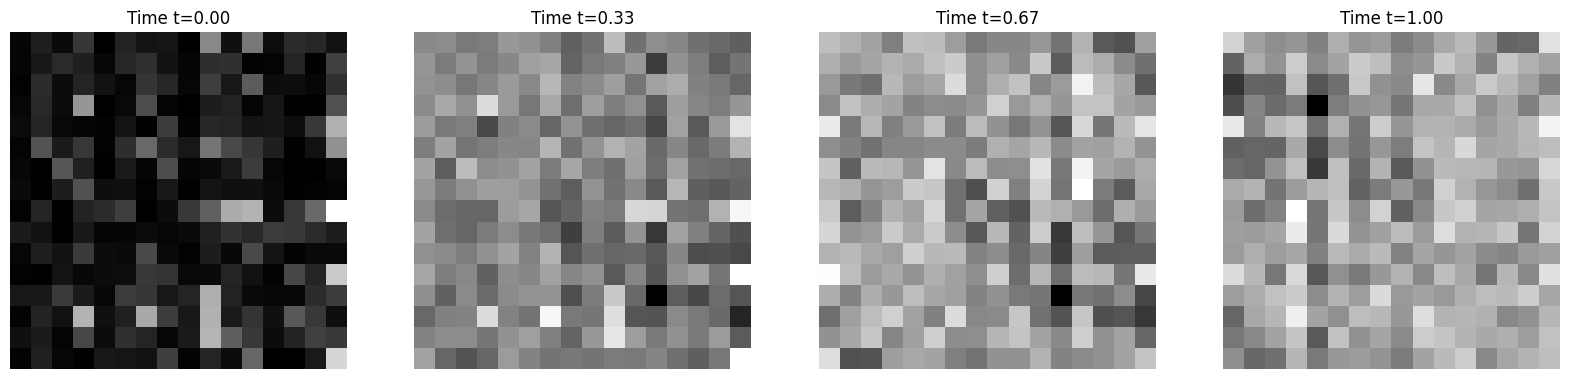

In [7]:
times = np.linspace(0, 1, 4)
fig, ax = plt.subplots(ncols=4, figsize=(20,20))

noisy_input = 2 * np.pi * np.random.random(8)

for idx, t in enumerate(times):
    # Generate and evolve image
    evolved_output = evolve_generated_image(quantum_generator, hamiltonian_tensor, t, noisy_input)
    
    # Get real part for visualization
    image = evolved_output.real.reshape(16, 16)
    
    ax[idx].imshow(image.numpy(), cmap='gray')
    ax[idx].title.set_text(f'Time t={t:.2f}')
    ax[idx].axis('off')

plt.show()

### Build discriminator

In [8]:
import torch
from torch import nn

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # Input shape: (batch_size, 1, 16, 16)
        self.conv_blocks = nn.Sequential(
            # First Conv Block
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # Output: (32, 16, 16)
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            
            # Second Conv Block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Output: (64, 16, 16)
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            
            # Third Conv Block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Output: (128, 16, 16)
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            
            # Fourth Conv Block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # Output: (256, 16, 16)
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4)
        )
        
        # Calculate input size for the fully connected layer
        self.fc_input_size = 256 * 16 * 16
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(self.fc_input_size, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # x shape: (batch_size, 1, 16, 16)
        x = self.conv_blocks(x)
        # Final output shape: (batch_size, 1)
        return self.fc(x)

# Create the discriminator
discriminator = Discriminator()

In [9]:
# Test the discriminator with a sample input
def test_discriminator():
    # Create a sample batch
    batch_size = 4
    sample_input = torch.randn(batch_size, 1, 16, 16)
    
    # Pass through discriminator
    output = discriminator(sample_input)
    
    print(f"Input shape: {sample_input.shape}")
    print(f"Output shape: {output.shape}")
    return output

# Run the test
test_output = test_discriminator()

Input shape: torch.Size([4, 1, 16, 16])
Output shape: torch.Size([4, 1])


In [10]:
# Generate random input for the generator
noisy_input = 2 * np.pi * np.random.random(8)

# Get output from quantum generator
with torch.no_grad():
    output = quantum_generator(torch.tensor(noisy_input, dtype=torch.float32))

# Reshape to match discriminator input format (batch, channels, height, width)
image = output.reshape(1, 1, 16, 16)  # (batch_size=1, channels=1, height=16, width=16)

# Get prediction using PyTorch discriminator
discriminator.eval()  # Set to evaluation mode
with torch.no_grad():
    prediction = discriminator(image)
    
print(f"Discriminator prediction: {prediction.item():.7f}")  # Close to 1 means "real", close to 0 means "fake"

Discriminator prediction: 0.5001394


# Construct training loop, the hardest part

### Define losses

In [12]:
def adversarial_loss(input, target):
    criterion = torch.nn.BCELoss()
    return criterion(input, target)

### Define optimizers

In [11]:
from torch.optim import Adam


g_lr = 0.0005  # Generator learning rate
d_lr = 0.00001  # Discriminator learning rate (smaller to train slower)

# Other hyperparameters
b1 = 0.7
b2 = 0.999

# Optimizers with different learning rates
generator_optimizer = Adam(quantum_generator.parameters(), lr=g_lr, betas=(b1, b2), weight_decay=0.005)

discriminator_optimizer = Adam(discriminator.parameters(), lr=d_lr, betas=(b1, b2), weight_decay=0.005)

### Plot losses

In [15]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

# Lists to store the loss values
generator_loss_values = []
discriminator_loss_values = []

def plot_training_progress():
    # Check if we have enough data to plot
    if len(generator_loss_values) < 2:
        return

    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

    # Plot losses
    ax1.set_title("Generator and Discriminator Loss")
    ax1.plot(generator_loss_values, label="Generator Loss", color="royalblue")
    ax1.plot(discriminator_loss_values, label="Discriminator Loss", color="magenta")
    ax1.legend(loc="best")
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Loss")
    ax1.grid(True)

    plt.tight_layout()
    plt.show()

# Function to update the loss values
def update_loss_values(g_loss, d_loss):
    generator_loss_values.append(g_loss)
    discriminator_loss_values.append(d_loss)

### Model training

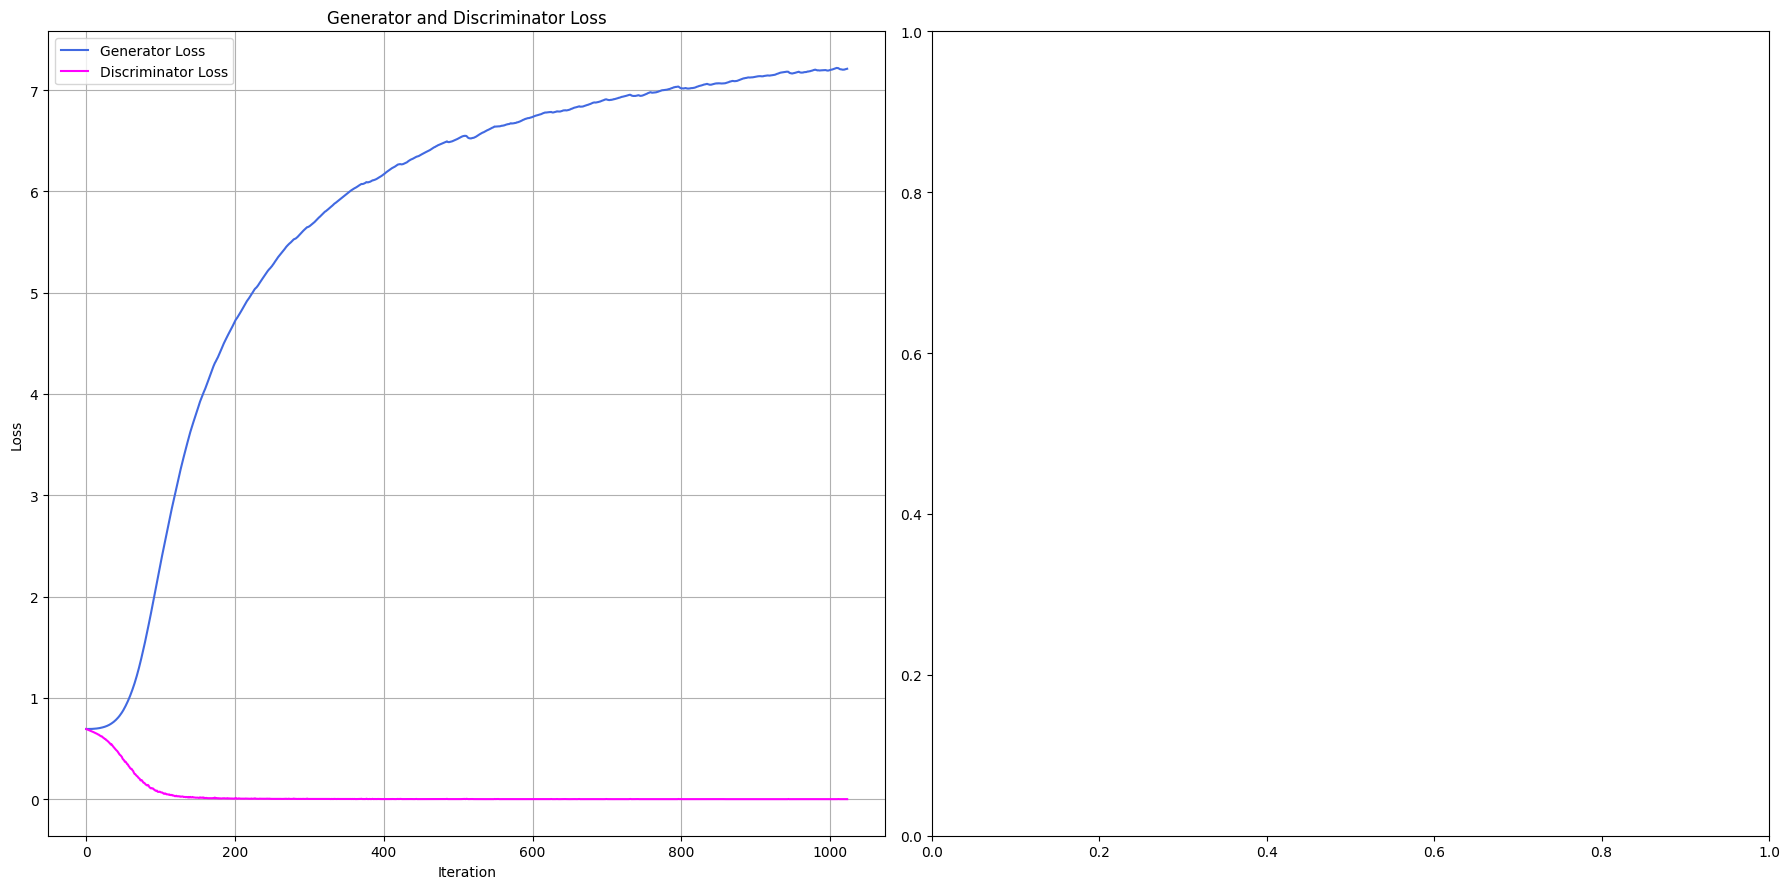

Training completed in 385.41 seconds


In [16]:
import time
import torch
from IPython.display import clear_output

n_epochs = 20
generator_loss_values = []
discriminator_loss_values = []

start = time.time()
for epoch in range(n_epochs):
    for batch in dataloader:  
        valid = torch.ones(BATCH_SIZE, 1)
        fake = torch.zeros(BATCH_SIZE, 1)
        
        # Initialize tensor for batch of generated images
        fake_images = torch.zeros(BATCH_SIZE, 1, 16, 16)
        
        # Generate images one at a time
        for i in range(BATCH_SIZE):

            noisy_input = 2 * np.pi * np.random.random(8)
            with torch.no_grad():
                gen_output = quantum_generator(torch.tensor(noisy_input, dtype=torch.float32))
            fake_images[i] = gen_output.reshape(1, 16, 16)
        
        # Get real images from dataloader
        real_images = batch[0]  # [0] because TensorDataset returns a tuple

        # Train Generator
        generator_optimizer.zero_grad()
        disc_output_fake = discriminator(fake_images)
        g_loss = adversarial_loss(disc_output_fake, valid)
        generator_loss_values.append(g_loss.item())
        g_loss.backward(retain_graph=True)
        generator_optimizer.step()

        # Train Discriminator
        discriminator_optimizer.zero_grad()
        disc_output_real = discriminator(real_images)
        disc_output_fake = discriminator(fake_images.detach())
        real_loss = adversarial_loss(disc_output_real, valid)
        fake_loss = adversarial_loss(disc_output_fake, fake)
        d_loss = (real_loss + fake_loss) / 2
        discriminator_loss_values.append(d_loss.item())
        d_loss.backward()
        discriminator_optimizer.step()

    # Print progress every 5 epochs
    if epoch % 5 == 0:
        print(f"Epoch [{epoch}/{n_epochs}]")
        print(f"D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")
        quantum_generator.latest_output = gen_output
        plot_training_progress()

elapsed = time.time() - start
print(f"Training completed in {elapsed:.2f} seconds")

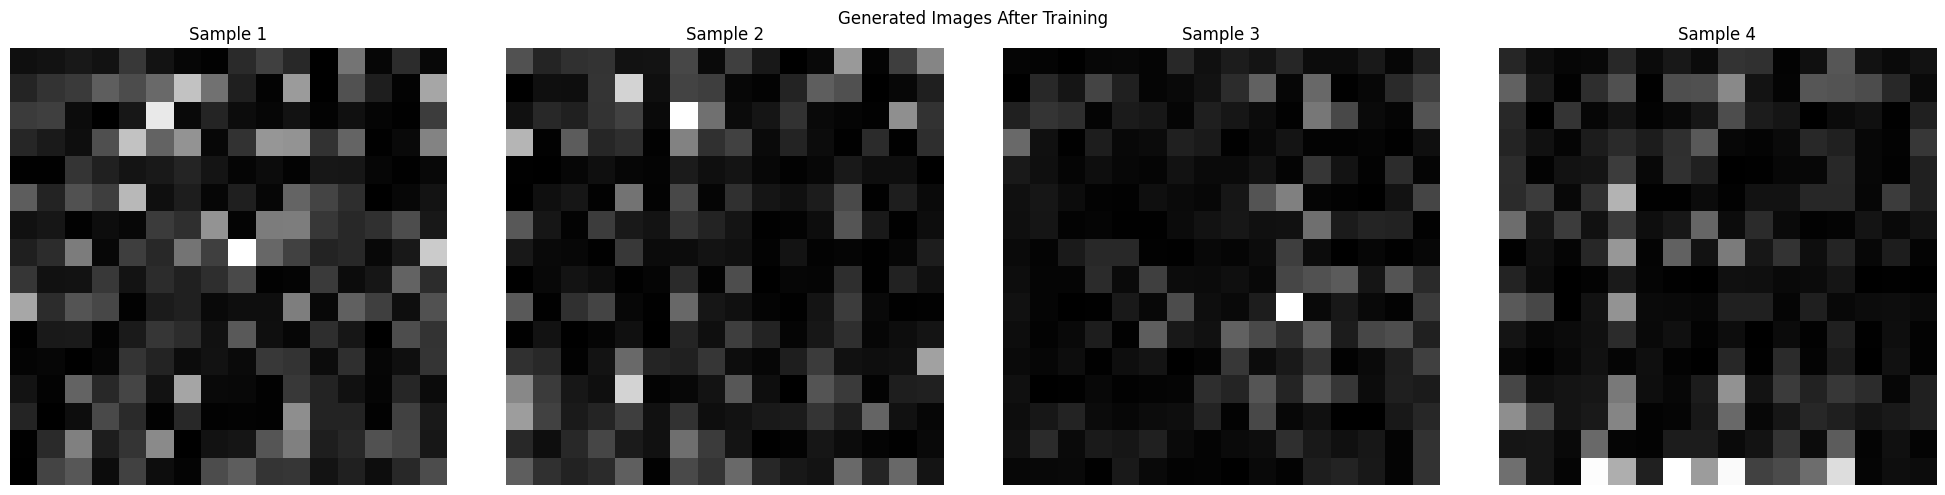

In [17]:
# After training is complete:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('Generated Images After Training')

for i in range(4):
    # Generate new random input
    noisy_input = 2 * np.pi * np.random.random(8)
    
    # Generate image with trained model
    with torch.no_grad():
        gen_output = quantum_generator(torch.tensor(noisy_input, dtype=torch.float32))
        image = gen_output.reshape(16, 16).numpy()
    
    # Plot the image
    axes[i].imshow(image, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'Sample {i+1}')

plt.tight_layout()
plt.show()